# CSE-602 Supervised Machine Learning Project

### GROUP MEMBERS:
**AYESHA NOOR KHAN (ERP 29460)**

**MARYAM KHAN (ERP 08635)**

**PROJECT GOAL:**

The goal of the project is to identify an imbalance class dataset and make the possible solution for it using Class Balancing Solutions.

**CI SOLUTIONS AND CLASSIFIERS USED:**

In this dataset we will be covering three Class Imbalance Solution:

1.   Resampling Method (SMOTE)
2.   Algorithmic Method (Class Weighting and Ensemble Method Bagging | Boosting)
3.   One-Class learning (OneClassSVM)

As it is a classification problem we will be evaluating the performance metrics on 5 classification algorithms:

1.   Decision Tree Classifier
2.   KNN Classifier
3.   Random Forest Classifier
4.   SVM Classifier
5.   Guassian Naive Bayes Classifier

**PROPOSED METHODOLOGY:**

We will be starting from our baseline dataset (imbalance) on above choosen models with best hyperparameters tuning.
We will train our model on imbalance dataset and record the performance metrics.
AFter that we will train our model with balance dataset and record the performance metrics,
In the end, we will make the comparison of our baseline executed model's metrics and CI solution based executed model's metrics.
This will give us the best possible model for our case of dataset.


**DATASET OVERVIEW:**

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. The dataset have a target column of Bankruptcy in which 1 means the company is bankrupt and 0 means it is not bankrupt.

For More Info: [View Taiwanese Bankruptcy Dataset Detail Information](https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction)



### INSTALL PACKAGES

In [ ]:
pip install pandas requests ucimlrepo Plotly

### IMPORT REQUIRED LIBRARIES

In [2]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.figure_factory as plotly

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

###FETCH DATASET AND EXTRACT FEATURES AND TARGET CLASS

In [3]:
#directly fetching dataset from uci repo
load_dataset = fetch_ucirepo(id=572)

# Extract features and targets
X = load_dataset.data.features
y = load_dataset.data.targets

In above cell, we have fetched our data directly from UCI Repo and extract the features in X variable and target class in y variable.

###DESCRIPTION OF DATASET

In [4]:
# Display basic information
print("METADATA OF COMPANIES'S BANKRUPTCY")
print("")
print("Dataset Name: ",load_dataset.metadata.name)
print("Repository URL: ",load_dataset.metadata.repository_url)
print("Abstract Of Dataset: ",load_dataset.metadata.abstract)
print("")
print("VARIABLES OF COMPANIES'S BANKRUPTCY")
print("")
print(load_dataset.variables)

METADATA OF COMPANIES'S BANKRUPTCY

Dataset Name:  Taiwanese Bankruptcy Prediction
Repository URL:  https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction
Abstract Of Dataset:  The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

VARIABLES OF COMPANIES'S BANKRUPTCY

                                                 name     role        type  \
0                                           Bankrupt?   Target     Integer   
1    ROA(C) before interest and depreciation befor...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3    ROA(B) before interest and depreciation after...  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liabili

#DATA CLEANING

###HANDLING NULL VALUES

In our case, the dataset doesnot have any null values but still we have done an approach of filling out null values with median of the X features, and verified the data cleaning.

In [5]:
X = X.fillna(X.median())
#X=X.drop(columns=['year'])
print("\nVerify Data Cleaning\n")
for col in X.columns.values:
    print(f"{col} : {len(X[X[col].isnull()==True])}")


Verify Data Cleaning

 ROA(C) before interest and depreciation before interest : 0
 ROA(A) before interest and % after tax : 0
 ROA(B) before interest and depreciation after tax : 0
 Operating Gross Margin : 0
 Realized Sales Gross Margin : 0
 Operating Profit Rate : 0
 Pre-tax net Interest Rate : 0
 After-tax net Interest Rate : 0
 Non-industry income and expenditure/revenue : 0
 Continuous interest rate (after tax) : 0
 Operating Expense Rate : 0
 Research and development expense rate : 0
 Cash flow rate : 0
 Interest-bearing debt interest rate : 0
 Tax rate (A) : 0
 Net Value Per Share (B) : 0
 Net Value Per Share (A) : 0
 Net Value Per Share (C) : 0
 Persistent EPS in the Last Four Seasons : 0
 Cash Flow Per Share : 0
 Revenue Per Share (Yuan ¥) : 0
 Operating Profit Per Share (Yuan ¥) : 0
 Per Share Net profit before tax (Yuan ¥) : 0
 Realized Sales Gross Profit Growth Rate : 0
 Operating Profit Growth Rate : 0
 After-tax Net Profit Growth Rate : 0
 Regular Net Profit Growth Rate

#REUSABLE FUNCTION

We have created few resuable functions, such as confusion metrics visualization, data distribution of target class visualization, model evaulating reusable function, just to make the code clean. :)

###CONFUSION MATRIX

In [6]:
def plot_confusion_matrix(ax, y_true, y_pred, metrics,clf_name, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')

    roc_auc_text = f"{metrics['roc_auc']:.2f}" if metrics['roc_auc'] is not None else 'N/A'
    metrics_text = f"""
    {clf_name} Performance Metrics:
    Accuracy  : {metrics['accuracy']:.2f}
    Precision : {metrics['precision']:.2f}
    Recall    : {metrics['recall']:.2f}
    F1 Score  : {metrics['f1_score']:.2f}
    ROC AUC   : {roc_auc_text}
    """

    # Adjust the text coordinates and alignment
    ax.text(x=1.3, y=0.9, s=metrics_text, ha='left', va='center',
            transform=ax.transAxes, fontsize=12, color='black', family='monospace')

###DATA DISTRIBUTION PLOT VISUALIZATION

In [7]:
def plot_data_distribution(y_train, title, pie_angle):
    plt.figure(figsize=(13, 4), facecolor=None, edgecolor=None)

    # Summary data
    total_samples = len(y_train)
    bankrupt_1_count = np.sum(y_train == 1).values
    bankrupt_0_count = np.sum(y_train == 0).values

    # First plot (Bar Chart)
    plt.subplot(1, 2, 1)
    y_train_series = pd.Series(np.ravel(y_train), name="Bankrupt")
    sns.countplot(x=y_train_series, palette=['#00e6ac', '#b32400'], legend=False, hue=y_train_series)
    plt.title(title)
    plt.xlabel('Bankrupt')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Bankrupt 0', 'Bankrupt 1'])
    # Display data summary on the plot
    plt.text(1.2, 0.2, f"Minority Class Bankrupt 1 = {bankrupt_1_count}\nMajority Class Bankrupt 0 = {bankrupt_0_count}\nTotal samples = {total_samples}",
             horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)

    # Second plot (Pie Chart)
    plt.subplot(1, 2, 2)
    unique, counts = np.unique(np.ravel(y_train), return_counts=True)
    labels = ['Bankrupt 0', 'Bankrupt 1']
    plt.pie(counts, labels=labels, autopct='%1.2f%%', startangle=pie_angle, colors=['#00e6ac', '#b32400'], explode=[0.09, 0.09])
    plt.title(title)

    plt.tight_layout()
    plt.show()

###EVALUATE MODELS

In [8]:
def evaluate_classifier(clf, clf_name,classifier_level, X_train, y_train, X_test, y_test):
    clf.fit(X_train, np.ravel(y_train))
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1_score': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    # Setup figure and axes
    fig, ax = plt.subplots(figsize=(10, 4))  # Using one plot for simplicity here\
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

    # Plot the confusion matrix with metrics
    plot_confusion_matrix(ax, y_test, y_pred, metrics,clf_name, title=f'{clf_name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    return {
        'Model Name': classifier_level+" "+clf_name,
        'Accuracy': f"{accuracy_score(y_test, y_pred):.2f}",
        'Precision': f"{precision_score(y_test, y_pred, average='macro'):.2f}",
        'Recall': f"{recall_score(y_test, y_pred, average='macro'):.2f}",
        'F1 Score': f"{f1_score(y_test, y_pred, average='macro'):.2f}",
        'ROC AUC': f"{roc_auc_score(y_test, y_prob):.2f}" if y_prob is not None else 'N/A'
    }

#EXPLORATORY DATA ANALYSIS

This is an important stage in our model building goal, as our Dataset of **"Taiwanese Bankruptcy Prediction"** is very large having 95 features and many of features cna be corelated, extra, can cause variance etc, for solution we want to have deeper look at our data.

###IS IT IMBALANCE CLASS DATASET ?

First we have to find whether our dataset is actually class imabalanced or not, as we are going to start our model training first thing we should check about the class distribution ration. So here we go:

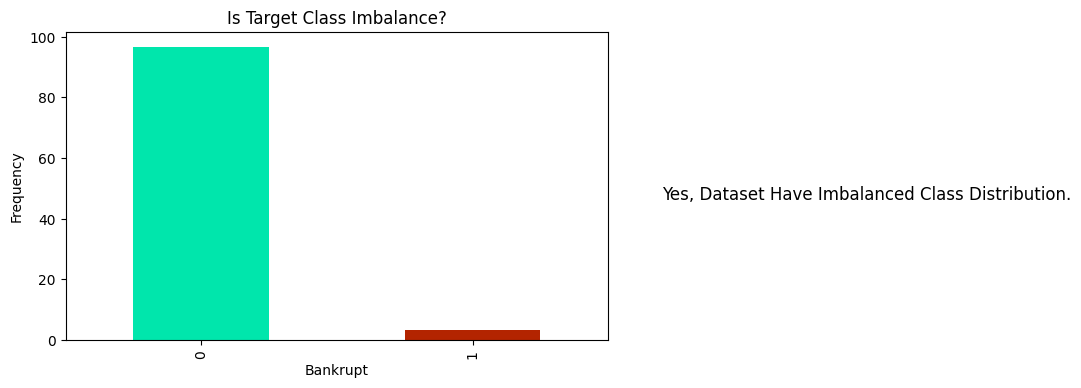

In [9]:
def check_imbalance(y, threshold=20):
    class_distribution = y.value_counts(normalize=True) * 100

    plt.figure(figsize=(7, 4), facecolor=None, edgecolor=None)
    ax = class_distribution.plot(kind="bar", color=['#00e6ac', '#b32400'])
    ax.set_xlabel("Bankrupt")
    ax.set_ylabel("Frequency")
    ax.set_title("Is Target Class Imbalance?")

    is_imbalanced = class_distribution.min() < threshold
    imbalance_text = f"Yes, Dataset Have Imbalanced Class Distribution." if is_imbalanced else f"No, Dataset Have Balanced Class Distribution."
    ax.text(1.1, 0.5, imbalance_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=12)

    plt.show()
check_imbalance(y['Bankrupt?'])

###DATASET DESCRIPTIVE STATISTICS

Next we have done a central way of viewing our dataset statistics , variability and distribution.

In [10]:
print("Summary :")
print(X.describe())
print(y)

Summary :
        ROA(C) before interest and depreciation before interest  \
count                                        6819.000000          
mean                                            0.505180          
std                                             0.060686          
min                                             0.000000          
25%                                             0.476527          
50%                                             0.502706          
75%                                             0.535563          
max                                             1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                 

###COORELATION HEATMAP

Then we have plot a Heatmap for our dataset which helps us to identify the correlation between our features as shown below:

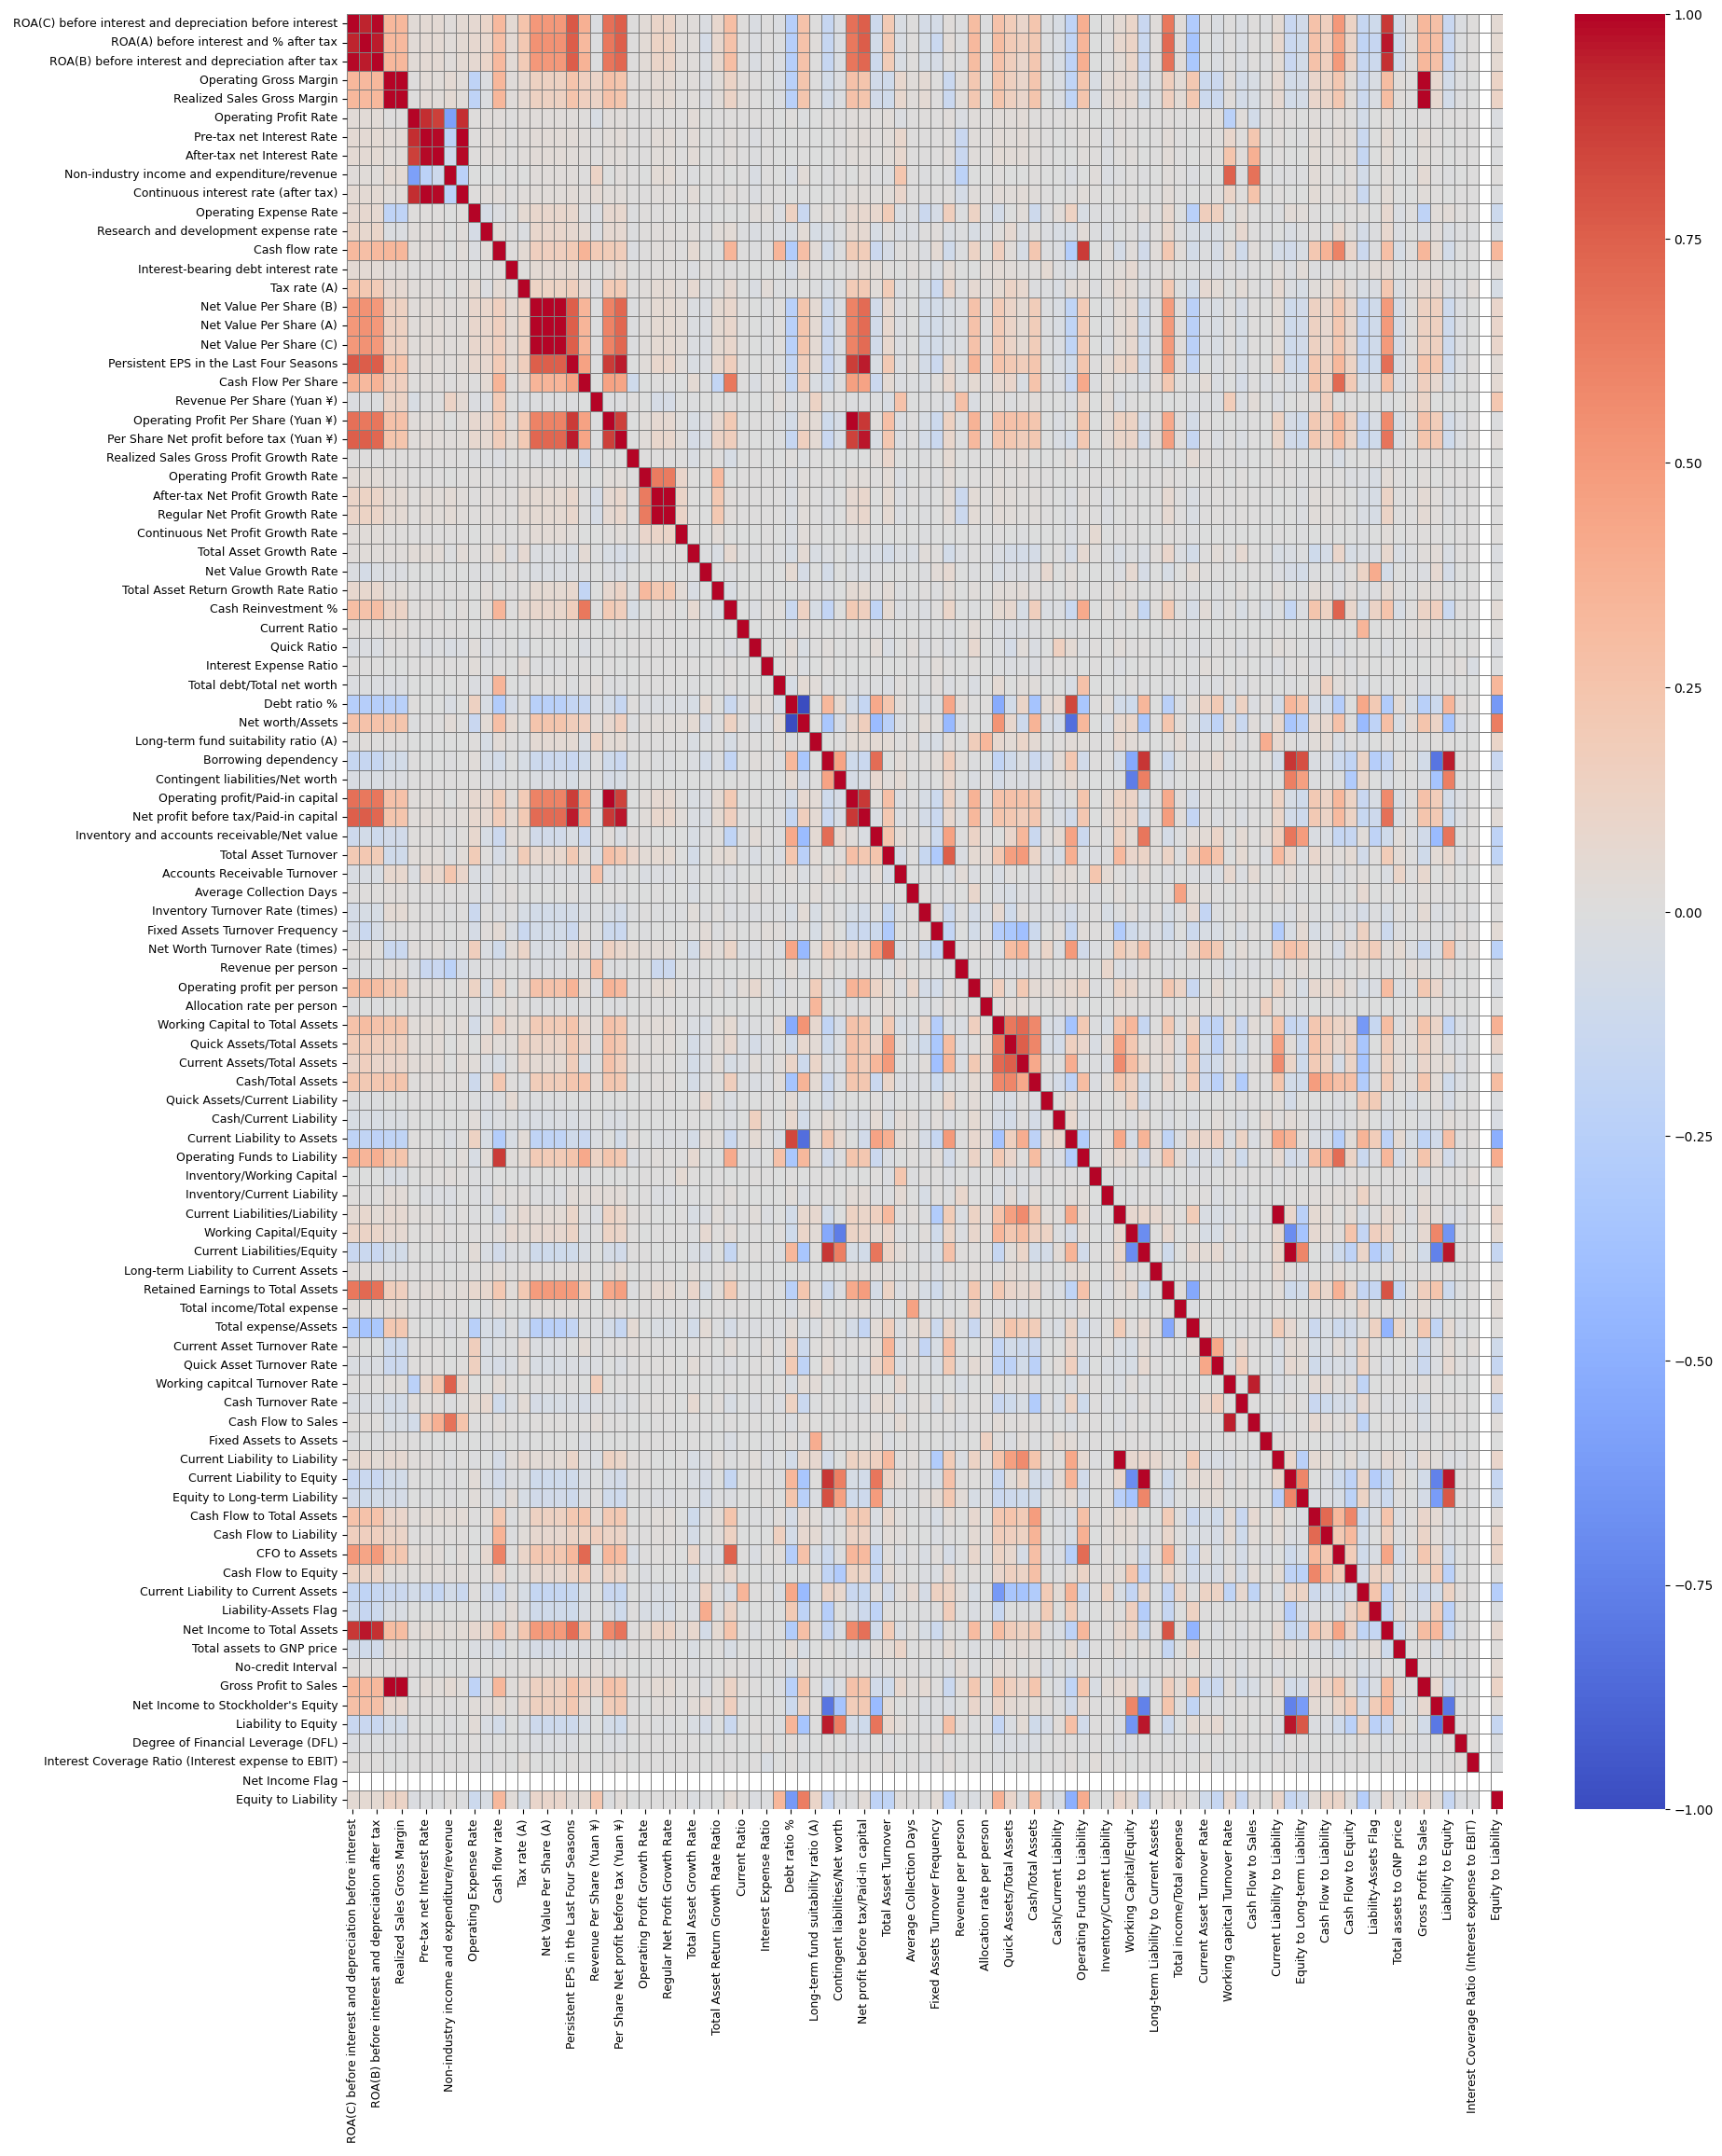

In [11]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Create the heatmap
plt.figure(figsize = (20,25))
sns.heatmap(correlation_matrix, cmap = 'coolwarm',linewidths=0.5,linecolor='grey')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

**HEATMAP OBSERVATION:** From above heatmap it is clearly visible that:

*   ROA(a), ROA(b) and ROA(c) are +ve correlated.
*   Net Value per Share (A,B and C) are highly correlated between each other.
*   After Tax Net Interest Rate and P re Tax Net Interest Rate are +ve  
    correlated.
*   Non-industry income and expenditure/revenue' is -ve correlated with
    Operating Profit Rate.
*   Operating Profit Growth Rate, After-tax Net Profit Growth Rate and
    Regular Net Profit Growth Rate are +ve correlated.
*   NPer Share Net profit before tax (Yuan ¥) and Persistent EPS in the Last
    Four Seasons are highely correlated.

# DIMENSIONALITY REDUCTION OR FEATURE SELECTION

Since it is a very high dimensional data, we need to apply dimensionality reduction using PCA and other methods if possible



###PCA FOR DIMENSIONALITY REDUCTION

In [12]:
from sklearn.decomposition import PCA
def do_pca(X_features):
    pca = PCA().fit(X_features)
    plt.figure(figsize = (5,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative sum - Explained Variance')
    #fitting PCA on our X
    pca = PCA(n_components=0.99).fit(X_features)
    print(f'Best value of n_component for 99% variance : {pca.n_components_}')

    pca = PCA(n_components=0.95).fit(X_features)
    print(f'Best value of n_component for 95% variance : {pca.n_components_}')

    pca = PCA(n_components=0.90).fit(X_features)
    print(f'Best value of n_component for 90% variance : {pca.n_components_}')

    pca = PCA(n_components=0.85).fit(X_features)
    print(f'Best value of n_component for 85% variance : {pca.n_components_}')

    pca = PCA(n_components=0.80).fit(X_features)
    print(f'Best value of n_component for 80% variance : {pca.n_components_}')
    print("\n")

###FEATURE SELECTION


We have also tried feature selection with random forest and SelecFromModel to give the top 20 features of the dataset

<ipython-input-26-4b88b6de1506>:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'))


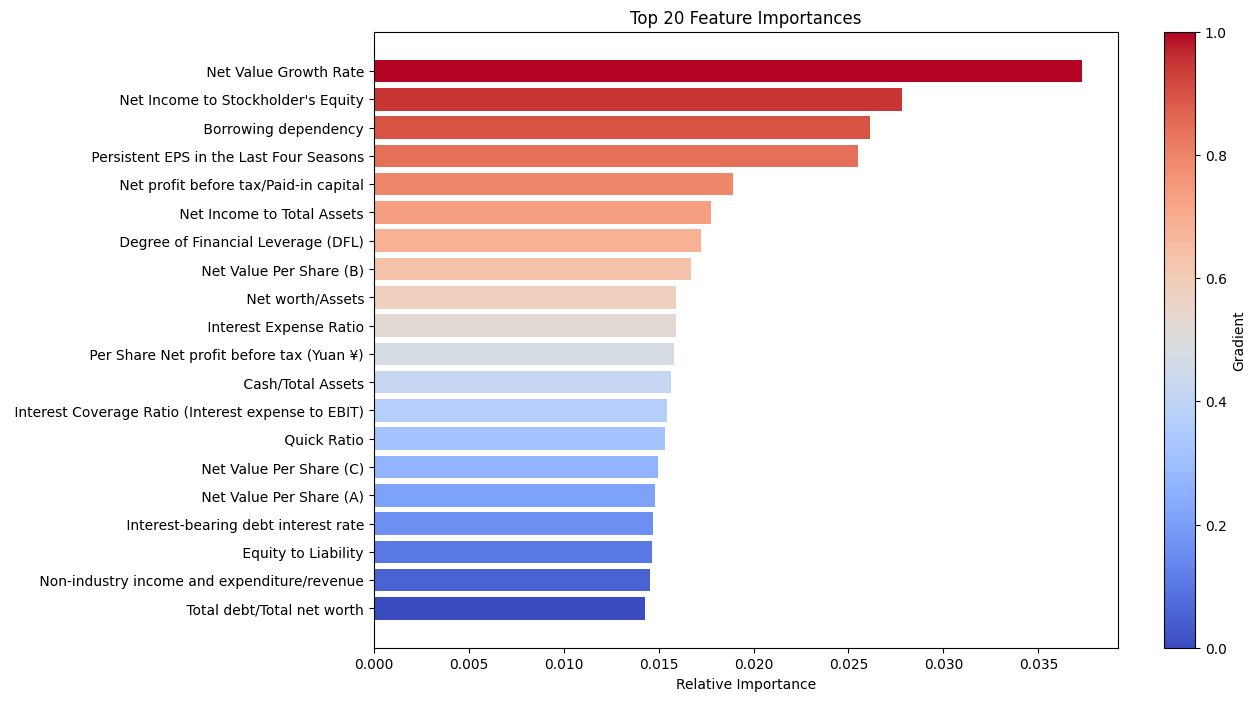

In [26]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X, np.ravel(y))

model_selector = SelectFromModel(model, prefit=True,threshold='median', max_features=20)
model_selector.fit(X, np.ravel(y))
X_selected = model_selector.transform(X)

selected_features = X.columns[model_selector.get_support()]

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)[-20:]  #Top 20 features

# Generate some random colors for demonstration purposes
colors = np.linspace(0, 1, len(indices))

plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances')

# Plot bar chart with gradient colors
bars = plt.barh(range(len(indices)), feature_importance[indices], color=plt.cm.coolwarm(colors), align='center')

# Set y-axis labels
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])

# Add color bar for reference
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'))
cbar.set_label('Gradient')

plt.xlabel('Relative Importance')
plt.show()

###EXPLORE MOST RELEVANT FEATURE:

In [34]:
X[' Net Value Growth Rate'].describe().apply("{0:,.0f}".format)

count            6,819
mean         1,566,212
std        114,159,390
min                  0
25%                  0
50%                  0
75%                  0
max      9,330,000,000
Name:  Net Value Growth Rate, dtype: object

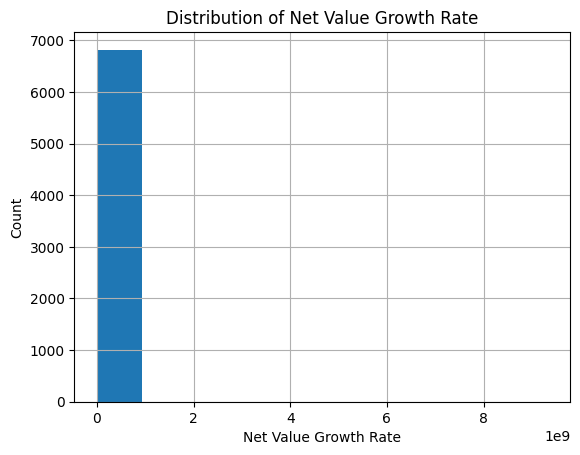

In [13]:
# Plot histogram of `A27`
X[" Net Value Growth Rate"].hist()
plt.xlabel("Net Value Growth Rate")
plt.ylabel("Count"),
plt.title("Distribution of Net Value Growth Rate");

#TRAINING AND TESTING DATA SPLITTING

We have split our 80% data into training set and 20% for testing, splitting is done with selected 11 features from PCA

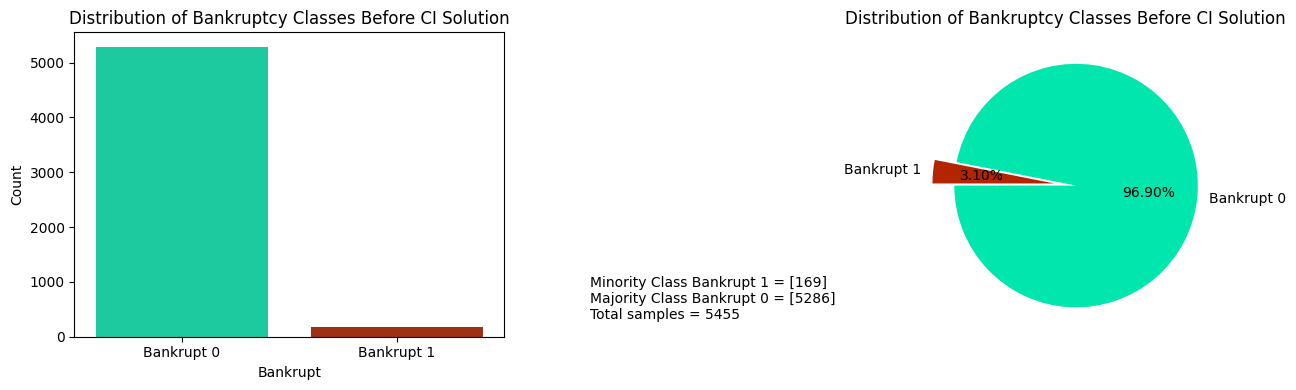

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42 )
plot_data_distribution(y_train,'Distribution of Bankruptcy Classes Before CI Solution',180)

#MODELS HYPERPARAMETER TUNING

For each selected model, we want the best hyperparamters on which the F1 score is best, for that we have made a reusable function for all 5 classifers hyper tuning. These function will give me the best hyper params of the classifiers for out dataset. We will call these fucntion later in our code when we will be running a baseline execution of all models.

**How it works?**

For our classifier, we have made set of all possible params and execute them one by one and the params by which our dataset has high F1 score is selected to be the best params and returned by model.

### DECISION TREE CLASSIFIER TUNING

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

def decision_tree_tuning(X_train, y_train, X_test, y_test, max_depth=None, criterion=None, min_samples_split=None):
    # Setting default parameters if None are provided
    if max_depth is None:
        max_depth = [10,20,25,30,35,40,50]
    if criterion is None:
        criterion = ['gini', 'entropy', 'log_loss']
    if min_samples_split is None:
        min_samples_split = [10,20,30,40]

    best_params = {}
    best_f1 = 0

    # Iterating through all combinations of parameters
    for criteria in criterion:
        for depth in max_depth:
            for min_samples in min_samples_split:
                dt = DecisionTreeClassifier(max_depth=depth, criterion=criteria, min_samples_split=min_samples)
                dt.fit(X_train, y_train)
                y_pred = dt.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='macro')

                # Update best parameters if current F1 score is higher
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        'criterion': criteria,
                        'max_depth': depth,
                        'min_samples_split': min_samples
                    }

    return {'best_params': best_params, 'best_f1_score': best_f1}

### KNN CLASSIFIER TUNING

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

def knn_tuning(X_train, y_train, X_test, y_test, n_neighbors=None, weights=None, metric=None):
    # Set default parameters if None are provided
    if n_neighbors is None:
        n_neighbors = [5,10,15,20,30,50,100,200]
    if weights is None:
        weights = ['uniform', 'distance']
    if metric is None:
        metric = ['euclidean', 'manhattan', 'minkowski']

    best_params = {}
    best_f1 = 0

    # Iterating through all combinations of parameters
    for neighbor in n_neighbors:
        for weight in weights:
            for m in metric:
                knn = KNeighborsClassifier(n_neighbors=neighbor, metric=m)
                knn.fit(X_train, np.ravel(y_train))
                y_pred = knn.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='macro')

                # Update best parameters if current F1 score is higher
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        'n_neighbors': neighbor,
                        'weights': weight,
                        'metric': m
                    }

    return {'best_params': best_params, 'best_f1_score': best_f1}

### RANDOM FOREST CLASSIFIER TUNING

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def random_forest_tuning(X_train, y_train, X_test, y_test, n_estimators=None, criterion=None):
    if n_estimators is None:
        n_estimators = [5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300, 400, 500]
    if criterion is None:
        criterion = ['entropy', 'gini']

    best_params = {}
    best_f1 = 0
    best_model = None

    for c in criterion:
        for estimator in n_estimators:
            rf = RandomForestClassifier(n_estimators=estimator, criterion=c)
            rf.fit(X_train, np.ravel(y_train))
            y_pred = rf.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'n_estimators': estimator, 'criterion': c}
                best_model = rf

    return {'best_params': best_params, 'best_f1_score': best_f1}

###SVM CLASSIFIER TUNING

In [21]:
def svm_tuning(X_train, y_train, X_test, y_test, C_values=None, kernels=None):
    if C_values is None:
        C_values = [10]
    if kernels is None:
        kernels = ['rbf']

    best_c = None
    best_kernel = None
    best_f1 = 0
    best_model = None

    # Iterate through all combinations of the specified parameters
    for C in C_values:
        for kernel in kernels:
            model = SVC(C=C, kernel=kernel, probability=True)
            model.fit(X_train, np.ravel(y_train))
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='macro')  # Calculate F1 score

            # Update the best parameters if the current F1 score is higher
            if f1 > best_f1:
                best_f1 = f1
                best_c = C
                best_kernel = kernel
                best_model = model

    return {
        'best_params': {
            'C': best_c,
            'kernel': best_kernel
        },
        'best_f1_score': best_f1
    }

###GNBAYES CLASSIFIER TUNING

In [22]:
def gn_bayes_tuning(X_train, y_train, X_test, y_test):
    # Initialize and train the Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train, np.ravel(y_train))

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate F1 score
    best_f1 = f1_score(y_test, y_pred, average='macro')

    return { 'best_params': { },'best_f1_score': best_f1}

#MODEL BUILDING WITH BEST HYPERPARAMETERS

Now here we will be getting best hyperparams for the models on which the we get best F1 scores as for for imbalanced dataset, precision and recall matters, whereas F1 score is the average of them.

In [23]:
decision_tree_best_hyperparam=decision_tree_tuning(X_train, y_train, X_test, y_test)['best_params']
knn_best_hyperparam=knn_tuning(X_train, y_train, X_test, y_test)['best_params']
random_forest_best_hyperparam=random_forest_tuning(X_train, y_train, X_test, y_test)['best_params']
svm_best_hyperparam=svm_tuning(X_train, y_train, X_test, y_test)['best_params']
gnbayes_best_hyperparam=gn_bayes_tuning(X_train, y_train, X_test, y_test)['best_params'] # Gaussian Naive Bayes typically does not need hyperparameter tuning


# Print best parameters (optional, for verification)
print("Decision Tree Best Params:", decision_tree_best_hyperparam)
print("\nKNN Best Params:", knn_best_hyperparam)
print("\nRandom Forest Best Params:", random_forest_best_hyperparam)
print("\nSVM Best Params:", svm_best_hyperparam)

Decision Tree Best Params: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 10}

KNN Best Params: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}

Random Forest Best Params: {'n_estimators': 15, 'criterion': 'gini'}

SVM Best Params: {'C': 10, 'kernel': 'rbf'}


Above results shows best hyperparams for all classiers in our dataset.
But remember, Guassian Naive Bayes doesn't support any hyperparam so it will be just executed simlply.

#BASELINE EXECUTION OF MODEL ON IMBALANCED DATA

Now we will be initializing the classifiers with best hyperparams.

Then we will be utilizing our reusable `evaluate_classifer` method to train our all 5 models and plot their results with confusion matrix and performance metrics (remember we will be having concern with precision and recall most in our imbalance class case)

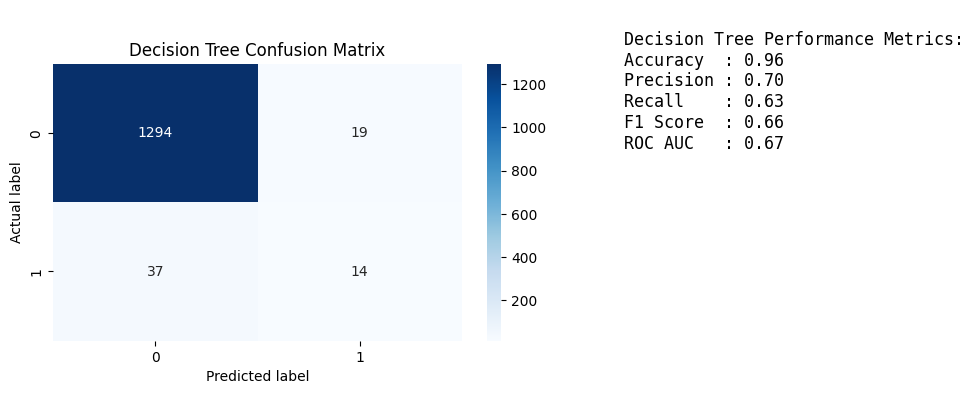

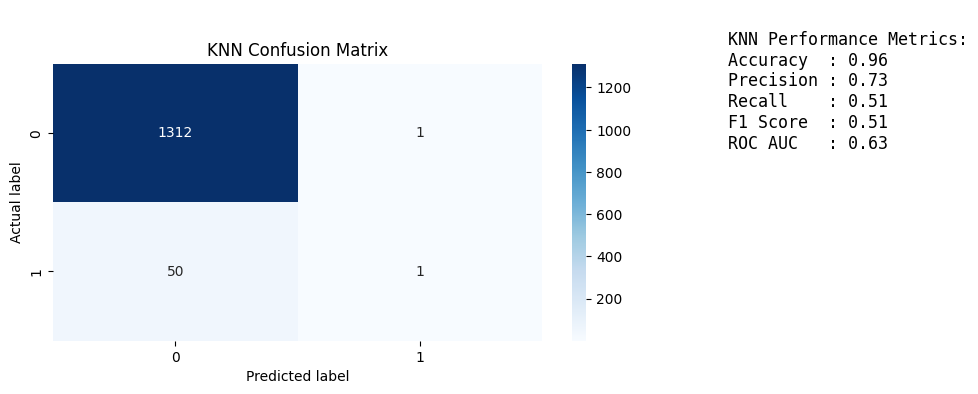

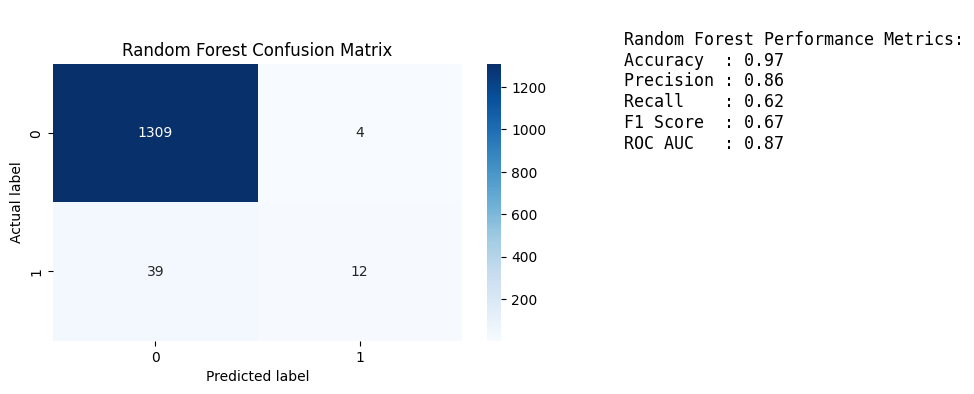

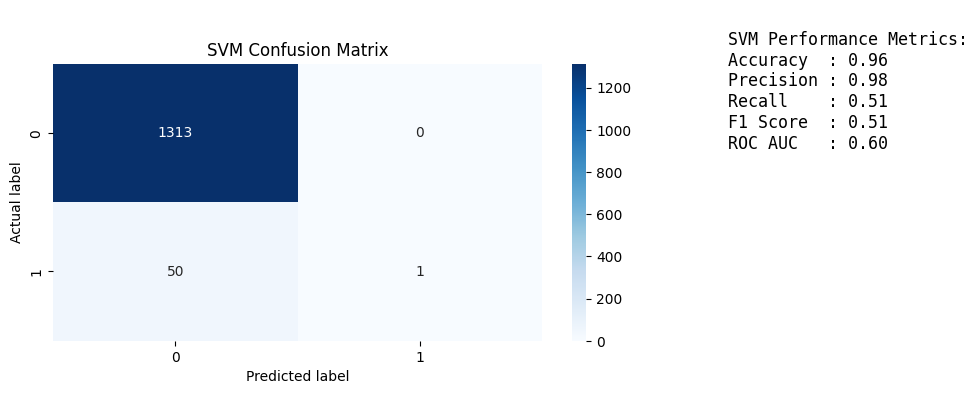

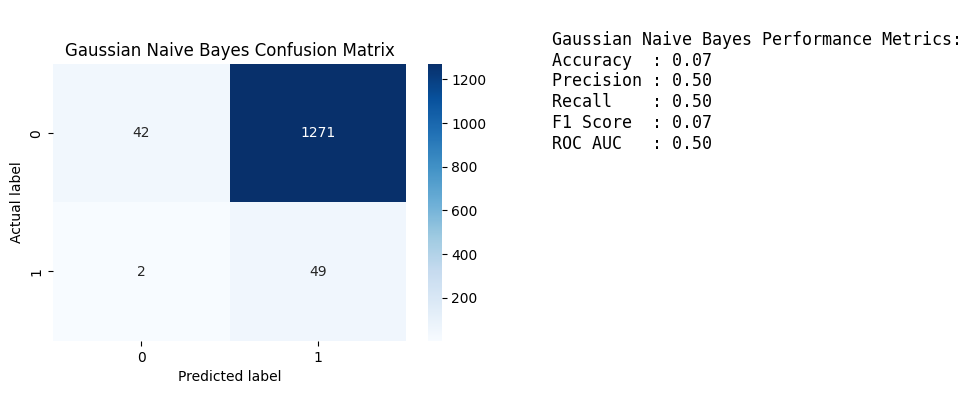

In [24]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(**decision_tree_best_hyperparam),
    "KNN": KNeighborsClassifier(**knn_best_hyperparam),
    "Random Forest": RandomForestClassifier(**random_forest_best_hyperparam),
    "SVM": SVC(**svm_best_hyperparam, probability=True), #prob true for ROC
    "Gaussian Naive Bayes": GaussianNB()  # Gaussian Naive Bayes typically does not need parameter tuning
}

# Collecting baseline_model_evaluation_results
baseline_model_evaluation_results=[]
for classifier_name, classifier in classifiers.items():
    model_eval_result = evaluate_classifier(classifier, classifier_name,"Baseline", X_train, y_train, X_test, y_test)
    baseline_model_evaluation_results.append(model_eval_result)

# Convert list to DataFrame
baseline_model_evaluation_results_df = pd.DataFrame(baseline_model_evaluation_results)

Summarizng the model performance metrics results in tabular form will give us better insights.

In [25]:
table = baseline_model_evaluation_results_df.to_markdown(index=False)
print(table)

| Model Name                    |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:------------------------------|-----------:|------------:|---------:|-----------:|----------:|
| Baseline Decision Tree        |       0.96 |        0.7  |     0.63 |       0.66 |      0.67 |
| Baseline KNN                  |       0.96 |        0.73 |     0.51 |       0.51 |      0.63 |
| Baseline Random Forest        |       0.97 |        0.86 |     0.62 |       0.67 |      0.87 |
| Baseline SVM                  |       0.96 |        0.98 |     0.51 |       0.51 |      0.6  |
| Baseline Gaussian Naive Bayes |       0.07 |        0.5  |     0.5  |       0.07 |      0.5  |


**As our dataset is imbalanced:**

🟪 **Accuracy Metric**: It is almost very high for all of the baseline execution methods giving the indication that our data has been overfitted alot. High accuracy shows the accuracy of only majority class not the minority class. Hence, accuracy performance metric will not be the best choice to evaluate models.

🟪 **Precision Metric**: It can be seen that Decision Tree model has the highest precision of 0.68 means it is better at minimizing the false positives which ultimately means that it is much better for predicting positive cases rather than other models.

🟪 **Recall Metric**:The recall metric is almost low accross all models, the highest recall is of Decision Tree model of 0.55, but significant number of positive cases have been missed by model which is a common problem in imbalance dataset.

🟪 **F1-score Metric**: It is relatively low for all models, means the challenge of balancing precison and recall should be cater first.

🟪 **ROC AUC Metric**: It is relatively low ranging from 0.59-0.66, means our models are poor at distinguish between positve and negative classes.

#CLASS BALANCING WITH RESAMPLING METHOD

As our performance metric are not overall good, we need to move forward with some class balancing solution, so first we will be trying SMOTE Resmapling Method. Let's get started.

###SMOTE RESAMPLING



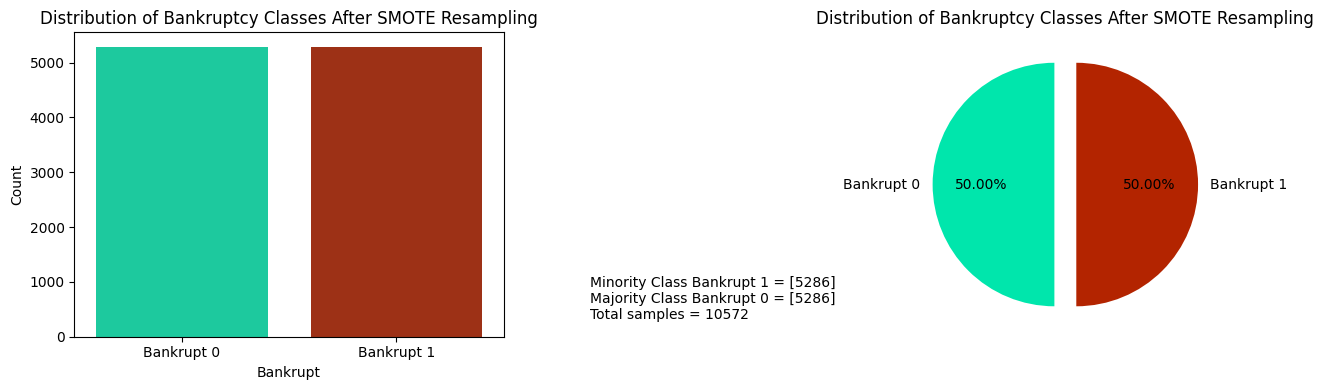

In [26]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
plot_data_distribution(y_train_smote,'Distribution of Bankruptcy Classes After SMOTE Resampling',90)

SMOTE have done the class balancing by creating synthetic sampling of minority data.

### 1. SMOTE + PCA

Best value of n_component for 99% variance : 11
Best value of n_component for 95% variance : 8
Best value of n_component for 90% variance : 7
Best value of n_component for 85% variance : 7
Best value of n_component for 80% variance : 6




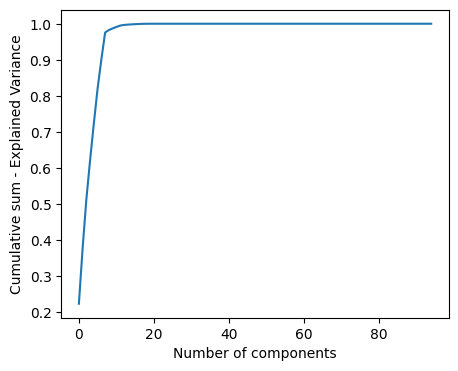

In [27]:
do_pca(X_train_smote)

Above results of PCA shows that 11 components are needed for the 99% variance in data. It can capture 99% of info in the dataset which can be acheive from top 11 features.

In [28]:
X_train_smote_PCA = PCA(11).fit_transform(X_train_smote)
pca = PCA(n_components=11).fit(X_train_smote)
X_test_PCA = pca.transform(X_test)

Now I have transform my smote X train features with PCA top 11 features, thus reducing the 95 features dimensionality reduction.

###MODELS EVALUTATION WITH CI SOLUTION SMOTE + PCA

Now we will use our `evaluate_classifer` method to train and evaluate the SMOTE model along with PCA dimensionality reduction.

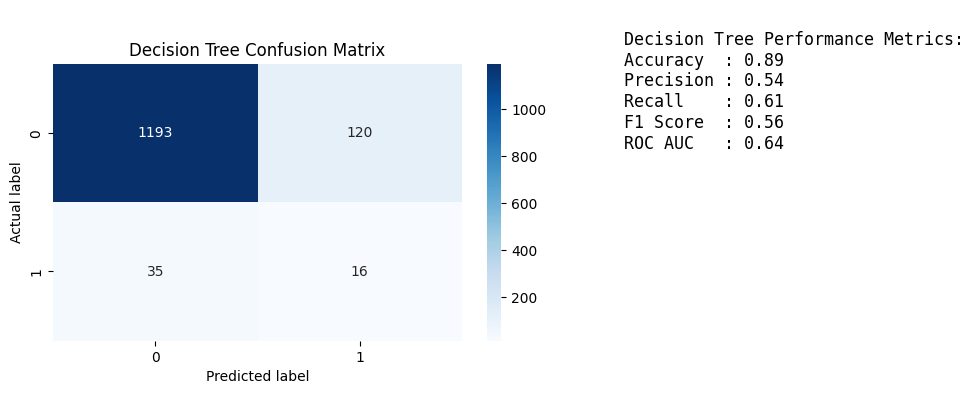

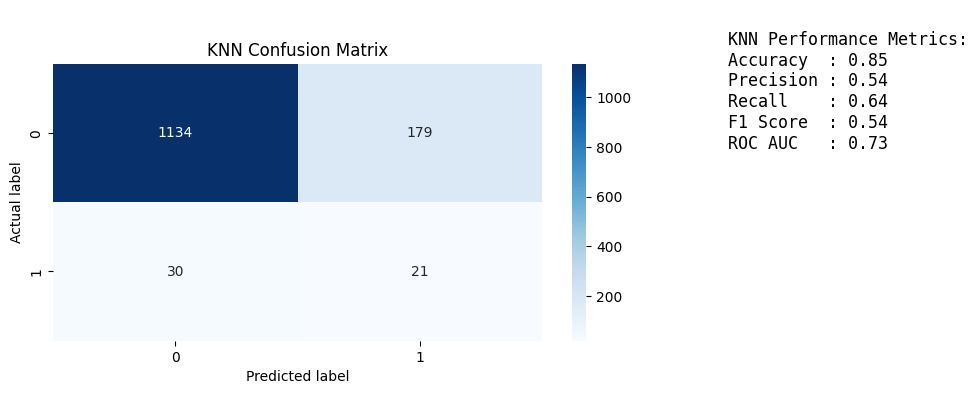

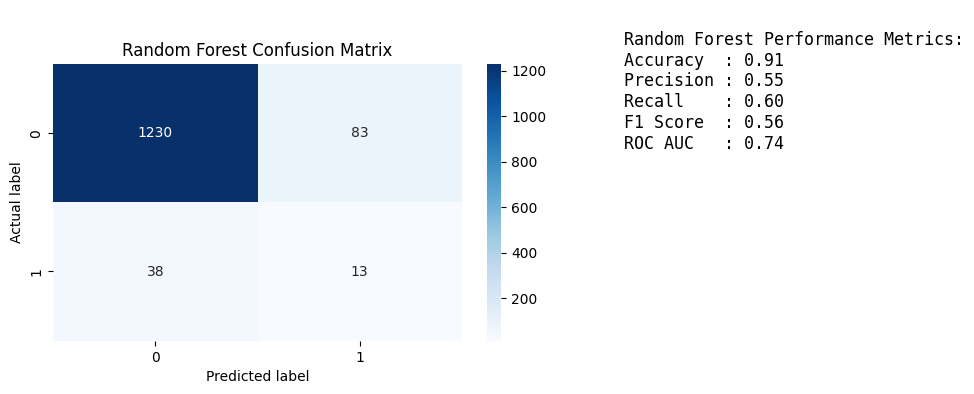

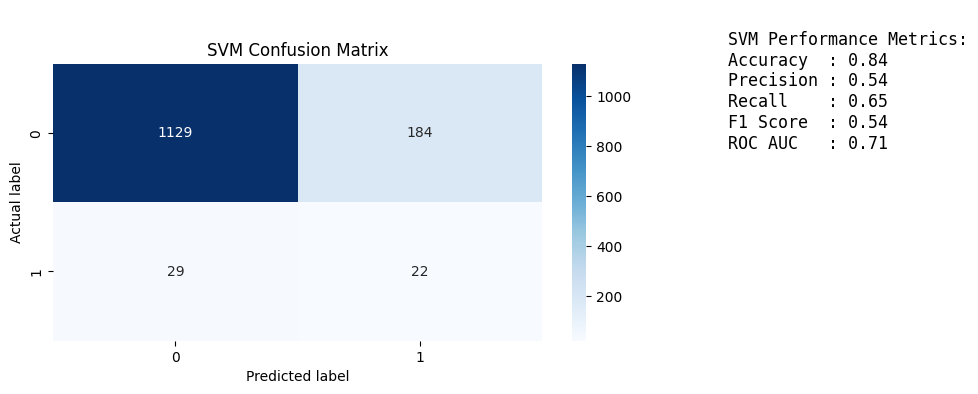

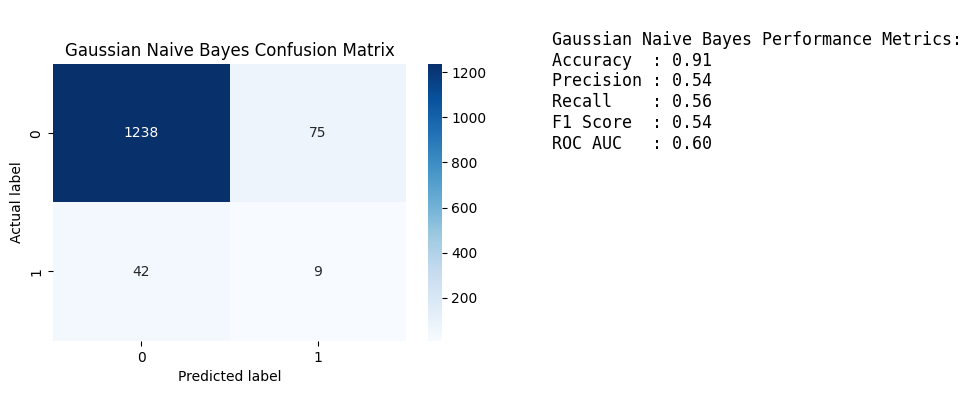

In [29]:
# Collecting results
smote_pca_model_evaluation_results=[]
for classifier_name, classifier in classifiers.items():
    model_eval_result = evaluate_classifier(classifier, classifier_name,"(SMOTE + PCA)", X_train_smote_PCA, y_train_smote, X_test_PCA, y_test)
    smote_pca_model_evaluation_results.append(model_eval_result)

# Convert list to DataFrame
smote_pca_model_evaluation_results_df = pd.DataFrame(smote_pca_model_evaluation_results)

Summarizng the model performance metrics results in tabular form will give us better insights.

In [30]:
table = smote_pca_model_evaluation_results_df.to_markdown(index=False)
print(table)

| Model Name                         |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:-----------------------------------|-----------:|------------:|---------:|-----------:|----------:|
| (SMOTE + PCA) Decision Tree        |       0.89 |        0.54 |     0.61 |       0.56 |      0.64 |
| (SMOTE + PCA) KNN                  |       0.85 |        0.54 |     0.64 |       0.54 |      0.73 |
| (SMOTE + PCA) Random Forest        |       0.91 |        0.55 |     0.6  |       0.56 |      0.74 |
| (SMOTE + PCA) SVM                  |       0.84 |        0.54 |     0.65 |       0.54 |      0.71 |
| (SMOTE + PCA) Gaussian Naive Bayes |       0.91 |        0.54 |     0.56 |       0.54 |      0.6  |


The above table shows the generalize description of SMOTE + PCA techniques on all the classifiers which we have used. Its performance metrics will be discussed in the end.

###MODELS EVALUTATION WITH CI SOLUTION SMOTE ONLY

Now we will use our `evaluate_classifer` method to train and evaluate the SMOTE model.

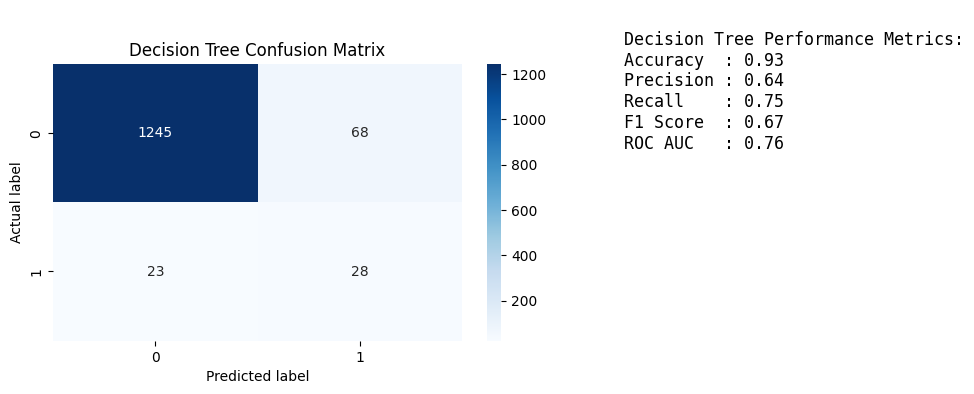

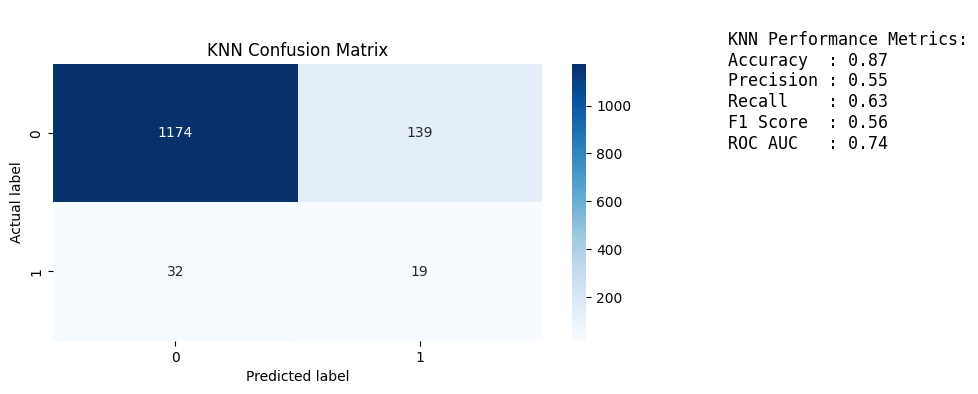

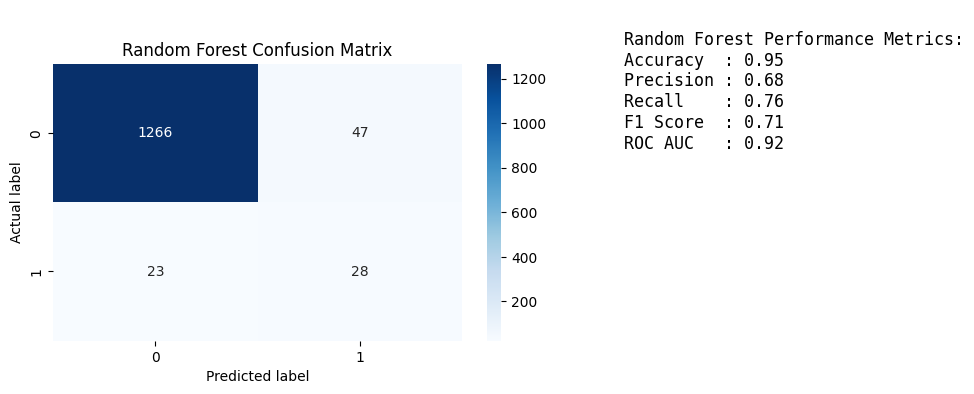

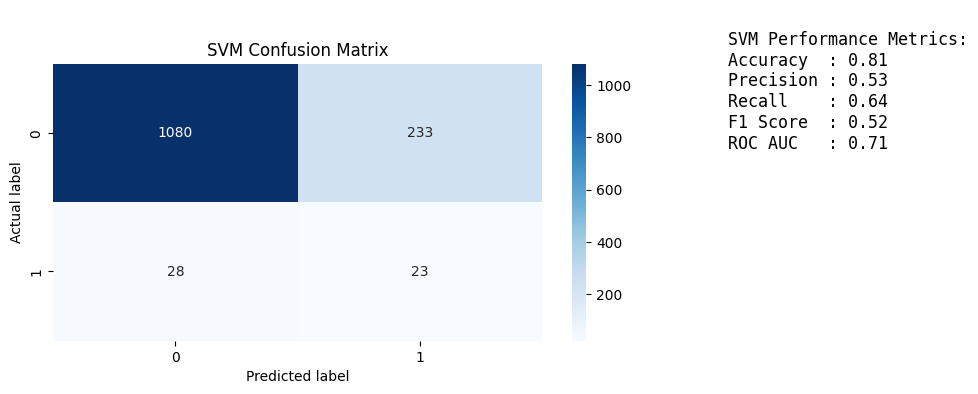

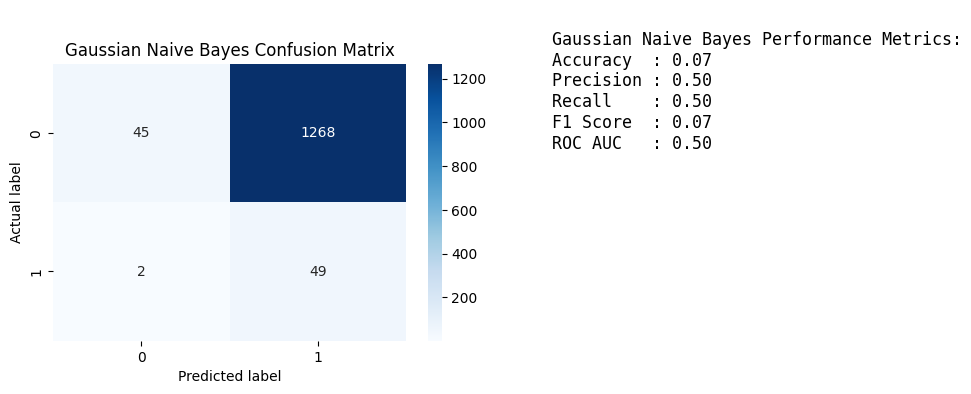

In [31]:
# Collecting results
smote_model_evaluation_results=[]
for classifier_name, classifier in classifiers.items():
    model_eval_result = evaluate_classifier(classifier, classifier_name,"(SMOTE)", X_train_smote, y_train_smote, X_test, y_test)
    smote_model_evaluation_results.append(model_eval_result)

# Convert list to DataFrame
smote_model_evaluation_results_df = pd.DataFrame(smote_model_evaluation_results)

Summarizng the model performance metrics results in tabular form will give us better insights.

In [32]:
table = smote_model_evaluation_results_df.to_markdown(index=False)
print(table)

| Model Name                   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:-----------------------------|-----------:|------------:|---------:|-----------:|----------:|
| (SMOTE) Decision Tree        |       0.93 |        0.64 |     0.75 |       0.67 |      0.76 |
| (SMOTE) KNN                  |       0.87 |        0.55 |     0.63 |       0.56 |      0.74 |
| (SMOTE) Random Forest        |       0.95 |        0.68 |     0.76 |       0.71 |      0.92 |
| (SMOTE) SVM                  |       0.81 |        0.53 |     0.64 |       0.52 |      0.71 |
| (SMOTE) Gaussian Naive Bayes |       0.07 |        0.5  |     0.5  |       0.07 |      0.5  |


The above table shows the generalize description of SMOTE techniques on all the classifiers which we have used. Its performance metrics will be discussed in the end.

# COMPARISON OF BASELINE AND SMOTE MODEL PERFORMANCE METRICS

In [33]:
combined_df = pd.concat([baseline_model_evaluation_results_df, smote_model_evaluation_results_df, smote_pca_model_evaluation_results_df], ignore_index=True)
table = combined_df.to_markdown(index=False)
print(table)

| Model Name                         |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:-----------------------------------|-----------:|------------:|---------:|-----------:|----------:|
| Baseline Decision Tree             |       0.96 |        0.7  |     0.63 |       0.66 |      0.67 |
| Baseline KNN                       |       0.96 |        0.73 |     0.51 |       0.51 |      0.63 |
| Baseline Random Forest             |       0.97 |        0.86 |     0.62 |       0.67 |      0.87 |
| Baseline SVM                       |       0.96 |        0.98 |     0.51 |       0.51 |      0.6  |
| Baseline Gaussian Naive Bayes      |       0.07 |        0.5  |     0.5  |       0.07 |      0.5  |
| (SMOTE) Decision Tree              |       0.93 |        0.64 |     0.75 |       0.67 |      0.76 |
| (SMOTE) KNN                        |       0.87 |        0.55 |     0.63 |       0.56 |      0.74 |
| (SMOTE) Random Forest              |       0.95 |        0.68 |     0.76 |      

#FINAL OBSERVATION:

---
### BASELINE MODELS:
---

🟪 **ACCURACY**:

From above analysis we can show the overall HIGH ACCURACY of all the models, but here high accuracy metric is not true as it captures the false negative cases.

🟪 **PRECISION AND RECALL:**

When it comes to Precision and Recall, SVM dominates the other models with 0.98 Precision means it has low rate of false positive prediction, but when it comes to recall its moderate thus SVM have misses almost majority of positive cases.
It can be seen that baseline Random Forest has maintain a good balance between precison and recall.

✅ **BEST PERFORMING MODEL:**

Random Forest Classifier shows a very good performance of accuracy, precision and recall than other models with accuracy (0.96), precision (0.77) and recall (0.63).

❌ **POOR PERFORMING MODEL:**

Guassian Naive Bayes shows a very poor performance of accuracy, precision and recall which indicates it might not be good model to use for imbalance dataset initially.

---
### RESAMPLING WITH SMOTE:
---

🟪 **ACCURACY**:

There is a slight decrease in accuracy after we done the oversampling and make the dataset balance with class. This decrease in accuracy predicted chances of recovering from the overfitting which we faced in Baseline model accuracies.

🟪 **PRECISION AND RECALL:**

The precison and recall for model execution after SMOTE shows the increase in recall that shows that the minority class is better recognized by oversampling.
Decison Tree and Random Forest have performed best after SMOTE.

✅ **BEST PERFORMING MODEL:**

Random Forest Classifier shows a very good performance of accuracy, precision and recall than other models with accuracy (0.94), precision (0.66) and recall (0.78).

❌ **POOR PERFORMING MODEL:**

Guassian Naive Bayes shows a very poor performance of accuracy, precision and recall again even after SMOTE resampling which indicates it might not be good model to use for imbalance dataset after resampling and with all feature set.


---
### RESAMPLING WITH SMOTE + PCA:
---

Its good to check our model with feature selection as well as to remove the correlated features or select the feature only which gives us high variance in maximum.

🟪 **ACCURACY**:

AFter PCA, the SMOTE values decreases the accuracy of the majority models except Guassian Naive Bayes, whose accuracy increased from 0.07 to 0.91 which is a huge increase. But overall PCA have decreased the model accuracy suggesting that there might be a loss of information.

🟪 **PRECISION AND RECALL:**

The precison and recall for model execution after SMOTE and PCA also shows the decrease as comapre to Baseline and simple SMOTE inidicates the PCA might make our model less computationally complex and stabilize the variance but it compromises on model sensitivity.

✅ **BEST PERFORMING MODEL:**

Guassian Naive Bayes shows a very good performance of accuracy, precision and recall than other models with accuracy (0.91), precision (0.54) and recall (0.56). But we will not consider these results as the accurate one due to our initial 2 approaches of finding best models.

❌ **POOR PERFORMING MODEL:**

Decision Tree, KNN, Random Forest, SVM all perform quite low in case of PCA.


---
### CONCLUSION:
---

✨ **RANDOM FOREST CLASSIFER** is the BEST choice of model so far, as its   
    accuracy (0.94), precision (0.66) and recall (0.78) is quite consistent and reliable for such Bankruptcy Predictions.

✨ It minimizes the False Negative (i.e. accurately predicted bankrupt companies as bankrupt) with HIGH RECALL than any other model.

✨ It maximizes the True Positive and minimizes the False Positive with HIGH PRECISION than any other model.



